# 프리랜서 마켓 플랫폼 '크몽' 앱 - 데이터 분석
* 작업 : 유진호
* 데이터 출처 : dsschool 실전분석반

# Index
* 0. 데이터 로드 & 설명
* 1. 데이터 전처리
* 2. 타 부서용 함수 구현
    - 1) 데이터 인덱싱 함수 구현 (마케팅팀 대상)
    - 2) PV 시각화 함수 구현 (운영/개발팀 대상)
* 3. 추가 분석, 시각화 & insight 도출
    - 1) 시간대별 유입자수 / 구매전환 분석
    - 2) 유입 채널별 전환
    - 3) OS별 설치/실행/활동 비교
    - 4) category 상품별 Funnel (구매전환) 분석

# 0. 데이터 로드 & 설명

### 총 3개의 데이터 테이블을 갖고와 분석 예정
- log : 크몽 앱에 대한 로그데이터 (크몽 앱 내 활동/전환을 나타냄)
- funnel : 크몽측에서 정해놓은 funnel 테이블 (퍼널 단계별 정리)
- category : 크몽측에서 정해놓은 category 테이블 (프리랜서 알선 플랫폼으로, 어떤 분야의 프리랜서인지 3단계 depth로 정리해놓음)


#### log 테이블의 컬럼 설명
* ```eventcategory```: 앱의 이벤트에 대한 카테고리입니다. 크게 다음의 종류가 있습니다.
  - ```install```: 앱설치
  - ```launch```: 앱실행 
  - ```deeplinkLaunch```: 딥링크 통한 앱실행
  - ```goal```: 앱 내에서의 활동 여부
  - ```exit```: 앱 종료
  - ```foreground```, background```: 앱을 foreground, background로 전환
  - ```launchlnSession```: Session의 시작.
* ```isfirstactivity```: 해당 이벤트가 해당 유저에 한하여 첫 번째인지 혹은 두 번째 이상인지를 알려주는 값입니다. 
  - boolean 형식으로, 해당 이벤트가 해당 유저에 한하여 첫 번째 이벤트이면 True, 아니면 False를 갖습니다.
* ```apppackagename```: 앱의 패키지의 고유한 이름입니다. 안드로이드의 경우 applicationId을, iOS의 경우 Bundle ID를 가져오게 됩니다.
* ```appversion```: kmong 어플리케이션의 버전입니다.
* ```devicetype```: 사용자가 kmong app을 실행하고 있는 기기의 제품명입니다.
* ```devicemanufacturer```: 사용자가 kmong app을 실행하고 있는 기기의 제조회사입니다. 
* ```osversion```: 사용자가 kmong app을 실행하고 있는 기기의 os 버전입니다.
* ```canonicaldeviceuuid```: 사용자가 kmong app을 실행하고 있는 기기의 고유 식별자입니다. (사용자를 구분하는 식별자로 이용할 수 있습니다)
* ```sourcetype```: 해당 로그를 만든 고객이 유입된 경로입니다. 유료 광고 채널, 바이럴 채널, 앱 마켓 등으로 구분합니다.
* ```channel```: sourcetype과 동일하지만 조금 더 세분화되어 있습니다.
  - unattributed, WEB, google-play, m_naver, google, (not set), google.adwords, m_naverpowercontents, pc_naver, apple.searchads, facebook, m_daum
* ```params_campaign```: 마케터가 입력한 캠페인 파라미터 중 캠페인명입니다. 
* ```params_medium```: 마케터가 입력한 캠페인 파라미터 중 매체입니다.
* ```params_term```: 마케터가 입력한 캠페인 파라미터 중 키워드입니다.
* ```inappeventcategory```: 인앱이벤트 식별자값으로 인앱이벤트를 지칭하는 3개의 값(category > action > label) 중 가장 상위에 속하는 구분값입니다.
  - ```eventcategory```가 goal인 경우에만 제공됩니다.
  - 차후에 읽어올 funnel 데이터셋과 연결할 수 있습니다.
  - ex) seller_selling_history.view, gig_detail.view
* ```inappeventlabel```: categoryid와 동일합니다.
  - 차후에 읽어올 category 데이터셋과 연결할 수 있습니다.
  - 인앱이벤트를 지칭하는 3개의 값(category > action > label) 중 마지막에 속하는 구분값입니다.
* ```eventdatetime```: 모바일 클라이언트 상에서의 실제 이벤트 발생시간입니다. ISO 8601 표준에 따라서 제공됩니다. 
* ```isfirstgoalactivity```: goal 이벤트의 경우, 해당 Goal Label, Description, Key, Category를 가진 이벤트가 해당 유저에 한하여 첫 번째인지 혹은 두 번째 이상 인지를 알려주는 boolean 값입니다. 예를 들어 동일한 유저로부터 두 번 이상의 같은 Goal 이벤트가 발생한 경우(e.g. 동일한 물건 재구매 등) 이 값은 false가 됩니다.

* ```event_rank```: 데이터를 정렬하는데 필요한 컬럼입니다. log엔 기록되지 않으며, DS_School에서 제공하는 전처리된 컬럼입니다.

In [1]:
import pandas as pd
import matplotlib
from IPython.display import set_matplotlib_formats

# 화면에 출력할 최대 컬럼 개수
pd.options.display.max_columns = 50

# 폰트 셋팅
matplotlib.rc('font', family='Malgun Gothic')

# 폰트를 바꿀 경우 마이너스가 표시되지 않는 경우 막아주는 코드
matplotlib.rc('axes', unicode_minus=False)

# retina 옵션을 통해 해상도 올림
set_matplotlib_formats('retina')

In [2]:
# log테이블에 해당하는  kmong-conversion.csv 파일 갖고오기
log = pd.read_csv('data/kmong-conversion.csv')
print(log.shape)
log.head()

(434244, 19)


,eventcategory,isfirstactivity,apppackagename,appversion,devicetype,devicemanufacturer,osversion,canonicaldeviceuuid,sourcetype,channel,params_campaign,params_medium,params_term,inappeventcategory,inappeventlabel,eventdatetime,rowuuid,isfirstgoalactivity,event_rank
0,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957,unattributed,unattributed,NaN,NaN,NaN,home.view,NaN,2018-09-28T00:00:00+09:00,fd2a188c-bc9b-4702-9c47-b546b2614817,False,True
1,goal,False,com.kmong.kmong,3.3.5,SM-N935S,samsung,Android7.0,8a871e50-0717-4aed-9bad-04ac3c3793be,unattributed,unattributed,NaN,NaN,NaN,gig_detail.view,41201.0,2018-09-28T00:00:00+09:00,e62dccef-dd70-4415-8a33-c8324ddaed38,False,True
2,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS12.0,A9E5778A-8F3D-4597-9718-74BF953A9F64,unattributed,unattributed,NaN,NaN,NaN,inbox_detail.view,NaN,2018-09-28T00:00:00+09:00,14eb3197-db83-493a-b7be-83582960c40b,False,True
3,foreground,NaN,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,168761CB-CB67-4592-867D-52780D651297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-28T00:00:01+09:00,f9bb91af-248b-44dc-9f5c-1c00b37ea97b,NaN,True
4,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,ACABB7C0-4C76-413A-B314-E5D6DA0D0E5D,viral,WEB,NaN,NaN,NaN,buyer_order_track.view,NaN,2018-09-28T00:00:02+09:00,236e9946-7801-4898-b609-06c8ab1139dc,False,True


**Funnel 테이블 갖고오기**

In [3]:
funnel = pd.read_csv('data/kmong-funnel.csv')
print(funnel.shape)
funnel.head()

(53, 6)


,Lv2,viewid,viewid desc,Lv1,funnel name,funnel desc
0,1100,home,홈 (탭),11,home,홈
1,1210,category_list,카테고리 목록 (탭),12,category,카테고리
2,1200,category_gig,카테고리-상품목록,12,category,카테고리
3,1300,search,검색,13,search,검색
4,1301,search_gig,검색-상품목록,13,search,검색


**categories 테이블 갖고오기**

In [4]:
categories = pd.read_csv('data/kmong-category.csv')

print(categories.shape)
categories.head(10)

(245, 9)


,depth,categoryid,categoryname,cat1_id,cat2_id,cat3_id,cat1,cat2,cat3
0,1,1,디자인,1,NaN,NaN,디자인,NaN,NaN
1,1,2,마케팅,2,NaN,NaN,마케팅,NaN,NaN
2,1,3,번역·통역,3,NaN,NaN,번역·통역,NaN,NaN
3,1,4,문서작성,4,NaN,NaN,문서작성,NaN,NaN
4,1,6,IT·프로그래밍,6,NaN,NaN,IT·프로그래밍,NaN,NaN
5,1,7,콘텐츠 제작,7,NaN,NaN,콘텐츠 제작,NaN,NaN
6,1,9,상담·컨설팅,9,NaN,NaN,상담·컨설팅,NaN,NaN
7,1,10,레슨,10,NaN,NaN,레슨,NaN,NaN
8,1,11,핸드메이드,11,NaN,NaN,핸드메이드,NaN,NaN
9,1,9901,크몽 인쇄소,99,NaN,NaN,특별 카테고리,NaN,NaN


# 1. 데이터 전처리
#### 전처리 내용
* log 테이블
    -  userid, rowuuid 그룹핑
    -  eventdatetime(시각)기준 오름차순 정렬
    -  inappeventcategory -> viewid , viewaction 컬럼으로 나누기
* funnel, categories 테이블과 병합
* osversion - ostype 컬럼으로 분리하기 (iOS11.4.1 -> iOS / 11.4.1)
* 처리 완료된 컬럼 제거, 불필요 컬럼 제거

### 1) 로그를 사용자별 Grouping - 컬럼정리

  * 사용자 아이디(```userid```)마다 그룹핑
  * 그룹핑이 된 사용자를 기준으로, '로그찍힌 시간대' 기준 오름차순 

In [5]:
# "canonicaldeviceuuid" = "userid" 교체
log.rename(columns={'canonicaldeviceuuid':'userid'}, inplace=True)

In [6]:
# eventdatetime -> date type 변경
log['eventdatetime'] = pd.to_datetime(log['eventdatetime'])
log['eventdatetime'].dtypes

datetime64[ns, pytz.FixedOffset(540)]

In [7]:
#### userid기준 grouping 하면서, eventdatetime(시각) 오름차순 정렬

In [68]:
#데이터 값 많으니, test 100개 우선 진행
logtop100 = log.head(100)

# groupby 된 상태에서는 sorting이 되지 않으므로, apply로 함수값을 개별 row별 진행
func = lambda x: x.sort_values(by='eventdatetime', ascending=True)
logtop100.groupby(['userid'], sort=False).apply(func).head()

,eventcategory,isfirstactivity,apppackagename,appversion,devicetype,devicemanufacturer,osversion,userid,sourcetype,channel,params_campaign,params_medium,params_term,inappeventcategory,inappeventlabel,eventdatetime,rowuuid,isfirstgoalactivity,event_rank
0,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957,unattributed,unattributed,NaN,NaN,NaN,home.view,NaN,2018-09-28 00:00:00+09:00,fd2a188c-bc9b-4702-9c47-b546b2614817,False,True
1,goal,False,com.kmong.kmong,3.3.5,SM-N935S,samsung,Android7.0,8a871e50-0717-4aed-9bad-04ac3c3793be,unattributed,unattributed,NaN,NaN,NaN,gig_detail.view,41201.0,2018-09-28 00:00:00+09:00,e62dccef-dd70-4415-8a33-c8324ddaed38,False,True
2,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS12.0,A9E5778A-8F3D-4597-9718-74BF953A9F64,unattributed,unattributed,NaN,NaN,NaN,inbox_detail.view,NaN,2018-09-28 00:00:00+09:00,14eb3197-db83-493a-b7be-83582960c40b,False,True
3,foreground,NaN,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,168761CB-CB67-4592-867D-52780D651297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-28 00:00:01+09:00,f9bb91af-248b-44dc-9f5c-1c00b37ea97b,NaN,True
4,goal,False,com.kmong.iOS,4.0.4,iPhone,Apple,iOS11.4.1,ACABB7C0-4C76-413A-B314-E5D6DA0D0E5D,viral,WEB,NaN,NaN,NaN,buyer_order_track.view,NaN,2018-09-28 00:00:02+09:00,236e9946-7801-4898-b609-06c8ab1139dc,False,True


In [69]:
# 전체 진행 (시간 좀 소요)
log_userid = log.groupby(['userid'], sort=False).apply(func)
log_userid.head()

eventcategory isfirstactivity  \
userid                                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 0            goal           False   
                                     131          goal            True   
                                     146          goal            True   
                                     155          goal           False   
                                     165          goal            True   

                                         apppackagename appversion devicetype  \
userid                                                                          
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 0    com.kmong.iOS      4.0.4     iPhone   
                                     131  com.kmong.iOS      4.0.4     iPhone   
                                     146  com.kmong.iOS      4.0.4     iPhone   
                                     155  com.kmong.iOS      4.0.4     iPhone   
                                     165  com.kmong.iOS      4.0.4     iPhone   

                                         devicemanufacturer  osversion  \
userid                                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 0                Apple  iOS11.4.1   
                                     131              Apple  iOS11.4.1   
                                     146              Apple  iOS11.4.1   
                                     155              Apple  iOS11.4.1   
                                     165              Apple  iOS11.4.1   

                                                                        userid  \
userid                                                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 0    F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957   
                                     131  F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957   
                                     146  F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957   
                                     155  F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957   
                                     165  F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957   

                                            sourcetype       channel  \
userid                                                                 
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 0    unattributed  unattributed   
                                     131  unattributed  unattributed   
                                     146  unattributed  unattributed   
                                     155  unattributed  unattributed   
                                     165  unattributed  unattributed   

                                         params_campaign params_medium  \
userid                                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 0               NaN           NaN   
                                     131             NaN           NaN   
                                     146             NaN           NaN   
                                     155             NaN           NaN   
                                     165             NaN           NaN   

                                         params_term  inappeventcategory  \
userid                                                                     
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 0           NaN           home.view   
                                     131         NaN  category_list.view   
                                     146         NaN   category_gig.view   
                                     155         NaN  category_list.view   
                                     165         NaN  bookmarks_gig.view   

                                          inappeventlabel  \
userid                                                      
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 0                NaN   
                                     131              NaN   
                                     146              1.0  

#### 'rowuuid' : 한 유저가 앱 내 활동시, '활동 기준'으로 찍히는 고유값 (추후 view, click등을 count 할때 활용)

In [10]:
# rowuuid 멀티인덱스
log_userid.set_index(['userid','rowuuid'], inplace=True)
log_userid.head()

eventcategory  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817          goal   
                                     a7b83557-49de-4728-9e00-762c923d3905          goal   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5          goal   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a          goal   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18          goal   

                                                                          isfirstactivity  \
userid                               rowuuid                                                
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817           False   
                                     a7b83557-49de-4728-9e00-762c923d3905            True   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5            True   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a           False   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18            True   

                                                                          apppackagename  \
userid                               rowuuid                                               
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  com.kmong.iOS   
                                     a7b83557-49de-4728-9e00-762c923d3905  com.kmong.iOS   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5  com.kmong.iOS   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a  com.kmong.iOS   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18  com.kmong.iOS   

                                                                          appversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817      4.0.4   
                                     a7b83557-49de-4728-9e00-762c923d3905      4.0.4   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5      4.0.4   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a      4.0.4   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18      4.0.4   

                                                                          devicetype  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817     iPhone   
                                     a7b83557-49de-4728-9e00-762c923d3905     iPhone   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5     iPhone   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a     iPhone   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18     iPhone   

                                                                          devicemanufacturer  \
userid                               rowuuid                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817              Apple   
                                     a7b83557-49de-4728-9e00-762c923d3905              Apple   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5              Apple   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a              Apple   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18              Apple   

                                                                           osversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-

#### inappeventcategory -> viewid , viewaction 컬럼으로 나누기
* inappeventcategory 컬럼에 view한 페이지정보와, action(view, click)이 뭉쳐져 있어 분리 필요.

In [11]:
# 정규표현식으로 '.' 기준 분리 test  
#'home.view' -> 'home', 'view'
import re
print(re.split('\.', 'home.view')[0])
print(re.split('\.', 'home.view')[1])

home
view


In [12]:
# '.'기준으로 - 앞은 viewid로 / 뒤는 viewaction 컬럼으로 생성
log_userid['viewid'] = log_userid.loc[pd.notnull(log_userid["inappeventcategory"]), 
               'inappeventcategory'].apply(lambda x: re.split('\.', x)[0])
log_userid['viewid'].unique()[:20]

array(['home', 'category_list', 'category_gig', 'bookmarks_gig',
       'gig_detail', nan, 'menu', 'seller_mileage_history',
       'seller_selling_history', 'inbox', 'inbox_detail',
       'seller_profits_history', 'notification', 'buyer_order_track',
       'seller_gig', 'buyer_order_history', 'notification_detail',
       'gig_detail_option', 'order_addOption', 'thankyou'], dtype=object)

In [13]:
log_userid['viewaction'] = log_userid.loc[pd.notnull(log_userid["inappeventcategory"]),
               'inappeventcategory'].apply(lambda x: re.split('\.', x)[1])

log_userid['viewaction'].value_counts()

view     296045
click      9488
Name: viewaction, dtype: int64

In [14]:
# 활용 완료된 컬럼 & 불필요 컬럼 제거
del log_userid['inappeventcategory']
del log_userid['apppackagename']
del log_userid['event_rank']

In [15]:
log_userid.head()

eventcategory  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817          goal   
                                     a7b83557-49de-4728-9e00-762c923d3905          goal   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5          goal   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a          goal   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18          goal   

                                                                          isfirstactivity  \
userid                               rowuuid                                                
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817           False   
                                     a7b83557-49de-4728-9e00-762c923d3905            True   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5            True   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a           False   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18            True   

                                                                          appversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817      4.0.4   
                                     a7b83557-49de-4728-9e00-762c923d3905      4.0.4   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5      4.0.4   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a      4.0.4   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18      4.0.4   

                                                                          devicetype  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817     iPhone   
                                     a7b83557-49de-4728-9e00-762c923d3905     iPhone   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5     iPhone   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a     iPhone   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18     iPhone   

                                                                          devicemanufacturer  \
userid                               rowuuid                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817              Apple   
                                     a7b83557-49de-4728-9e00-762c923d3905              Apple   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5              Apple   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a              Apple   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18              Apple   

                                                                           osversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  iOS11.4.1   
                                     a7b83557-49de-4728-9e00-762c923d3905  iOS11.4.1   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5  iOS11.4.1   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a  iOS11.4.1   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18  iOS11.4.1   

                                                                             sourcetype  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  una

### 2)  log, funnel, categories 컬럼 병합

In [16]:
# 필요한 컬럼만 갖고와서
funnel2 = funnel[['viewid','viewid desc', 'funnel name', 'funnel desc']]

In [17]:
# log , funnel 병합  - 'viewid'기준 (어떤 페이지를 view/click했는지 기준)
log_funnel = pd.merge(log_userid, funnel2, how='left', on = 'viewid').set_index(log_userid.index)
log_funnel.head()

eventcategory  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817          goal   
                                     a7b83557-49de-4728-9e00-762c923d3905          goal   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5          goal   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a          goal   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18          goal   

                                                                          isfirstactivity  \
userid                               rowuuid                                                
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817           False   
                                     a7b83557-49de-4728-9e00-762c923d3905            True   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5            True   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a           False   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18            True   

                                                                          appversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817      4.0.4   
                                     a7b83557-49de-4728-9e00-762c923d3905      4.0.4   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5      4.0.4   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a      4.0.4   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18      4.0.4   

                                                                          devicetype  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817     iPhone   
                                     a7b83557-49de-4728-9e00-762c923d3905     iPhone   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5     iPhone   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a     iPhone   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18     iPhone   

                                                                          devicemanufacturer  \
userid                               rowuuid                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817              Apple   
                                     a7b83557-49de-4728-9e00-762c923d3905              Apple   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5              Apple   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a              Apple   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18              Apple   

                                                                           osversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  iOS11.4.1   
                                     a7b83557-49de-4728-9e00-762c923d3905  iOS11.4.1   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5  iOS11.4.1   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a  iOS11.4.1   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18  iOS11.4.1   

                                                                             sourcetype  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  una

In [18]:
# categories 테이블도 병합 - 'categoryid'기준 (카테고리 대분류)
merge = pd.merge(log_funnel, categories, how='left', 
         left_on='inappeventlabel', right_on = 'categoryid').set_index(log_funnel.index)
merge.head()

eventcategory  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817          goal   
                                     a7b83557-49de-4728-9e00-762c923d3905          goal   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5          goal   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a          goal   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18          goal   

                                                                          isfirstactivity  \
userid                               rowuuid                                                
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817           False   
                                     a7b83557-49de-4728-9e00-762c923d3905            True   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5            True   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a           False   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18            True   

                                                                          appversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817      4.0.4   
                                     a7b83557-49de-4728-9e00-762c923d3905      4.0.4   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5      4.0.4   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a      4.0.4   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18      4.0.4   

                                                                          devicetype  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817     iPhone   
                                     a7b83557-49de-4728-9e00-762c923d3905     iPhone   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5     iPhone   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a     iPhone   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18     iPhone   

                                                                          devicemanufacturer  \
userid                               rowuuid                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817              Apple   
                                     a7b83557-49de-4728-9e00-762c923d3905              Apple   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5              Apple   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a              Apple   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18              Apple   

                                                                           osversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  iOS11.4.1   
                                     a7b83557-49de-4728-9e00-762c923d3905  iOS11.4.1   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5  iOS11.4.1   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a  iOS11.4.1   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18  iOS11.4.1   

                                                                             sourcetype  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  una

In [19]:
# column 처리 - 중복, 불필요 컬럼 제거
merge.drop(['inappeventlabel', 'cat1_id', 'cat2_id', 'cat3_id'], axis=1, inplace=True)

In [20]:
#컬럼명 직관적으로 변경
merge.rename(columns={'cat1':'category1', 'cat2':'category2', 'cat3':'category3'}, 
             inplace=True)

In [21]:
merge.head()

eventcategory  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817          goal   
                                     a7b83557-49de-4728-9e00-762c923d3905          goal   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5          goal   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a          goal   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18          goal   

                                                                          isfirstactivity  \
userid                               rowuuid                                                
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817           False   
                                     a7b83557-49de-4728-9e00-762c923d3905            True   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5            True   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a           False   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18            True   

                                                                          appversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817      4.0.4   
                                     a7b83557-49de-4728-9e00-762c923d3905      4.0.4   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5      4.0.4   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a      4.0.4   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18      4.0.4   

                                                                          devicetype  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817     iPhone   
                                     a7b83557-49de-4728-9e00-762c923d3905     iPhone   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5     iPhone   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a     iPhone   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18     iPhone   

                                                                          devicemanufacturer  \
userid                               rowuuid                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817              Apple   
                                     a7b83557-49de-4728-9e00-762c923d3905              Apple   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5              Apple   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a              Apple   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18              Apple   

                                                                           osversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  iOS11.4.1   
                                     a7b83557-49de-4728-9e00-762c923d3905  iOS11.4.1   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5  iOS11.4.1   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a  iOS11.4.1   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18  iOS11.4.1   

                                                                             sourcetype  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817  una

#### osversion -  ostype 컬럼으로 분리하기 (iOS11.4.1 -> iOS / 11.4.1)

In [22]:
# 정규표현식 test
re.findall('[a-zA-Z]+', 'iOS11.4.1')
re.findall('[\d\.]+', 'iOS11.4.1')[0]

'11.4.1'

In [23]:
# 함수 활용하여 변경
merge['ostype'] = merge['osversion'].apply(lambda x: re.findall('[a-zA-Z]+', x)[0])

In [24]:
merge['osversion'] = merge['osversion'].apply(lambda x: re.findall('[\d\.]+', x)[0])

### 컬럼 순서변경

In [25]:
# 내 컬럼 확인
merge.columns

Index(['eventcategory', 'isfirstactivity', 'appversion', 'devicetype',
       'devicemanufacturer', 'osversion', 'sourcetype', 'channel',
       'params_campaign', 'params_medium', 'params_term', 'eventdatetime',
       'isfirstgoalactivity', 'viewid', 'viewaction', 'viewid desc',
       'funnel name', 'funnel desc', 'depth', 'categoryid', 'categoryname',
       'category1', 'category2', 'category3', 'ostype'],
      dtype='object')

In [26]:
# 필요없는애들 나머지 삭제
merge.drop(['funnel name', 'depth', 'categoryid'], axis=1, inplace=True)

In [28]:
# columns 순서 최종 변경
col=['eventdatetime','devicemanufacturer','devicetype','ostype','osversion','appversion',
     'eventcategory','viewid','viewaction','funnel desc','viewid desc',
     'categoryname','category1','category2','category3','sourcetype','channel',
     'params_campaign','params_medium','params_term',
     'isfirstactivity','isfirstgoalactivity']
len(col) 

22

In [29]:
merge = merge[col]

## 데이터 전처리 완료

In [30]:
print(merge.shape)
merge.head()

(434244, 22)


eventdatetime  \
userid                               rowuuid                                                          
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817 2018-09-28 00:00:00+09:00   
                                     a7b83557-49de-4728-9e00-762c923d3905 2018-09-28 00:00:43+09:00   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5 2018-09-28 00:00:47+09:00   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a 2018-09-28 00:00:52+09:00   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18 2018-09-28 00:00:54+09:00   

                                                                          devicemanufacturer  \
userid                               rowuuid                                                   
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817              Apple   
                                     a7b83557-49de-4728-9e00-762c923d3905              Apple   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5              Apple   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a              Apple   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18              Apple   

                                                                          devicetype  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817     iPhone   
                                     a7b83557-49de-4728-9e00-762c923d3905     iPhone   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5     iPhone   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a     iPhone   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18     iPhone   

                                                                          ostype  \
userid                               rowuuid                                       
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817    iOS   
                                     a7b83557-49de-4728-9e00-762c923d3905    iOS   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5    iOS   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a    iOS   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18    iOS   

                                                                          osversion  \
userid                               rowuuid                                          
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817    11.4.1   
                                     a7b83557-49de-4728-9e00-762c923d3905    11.4.1   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5    11.4.1   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a    11.4.1   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18    11.4.1   

                                                                          appversion  \
userid                               rowuuid                                           
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817      4.0.4   
                                     a7b83557-49de-4728-9e00-762c923d3905      4.0.4   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5      4.0.4   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a      4.0.4   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18      4.0.4   

                                                                          eventcategory  \
userid                               rowuuid                                              
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817   

In [31]:
# 최종컬럼 csv로 저장 'kmong_merge_final.csv'
merge.to_csv('data/kmong_merge_final.csv')

# 2. 타 부서용 함수 구현
## 1) 데이터 인덱싱 함수 구현 (마케팅팀 대상)
  * 특정 사용자 아이디(```userid```) 또는, 특정 사용자 아이디를 리스트로 여러 개 넣으면, 해당 사용자들의 로그 데이터만 별도 색인되도록
  * 특정 ```column```을 리스트로 넣으면 해당 컬럼만 별도로 색인되도록
  * 특정 ```viewid```를 리스트로 넣으면 그 ```viewid```에 해당하는 로그 데이터만 별도로 색인되도록
  * ```userid```, ```columns```, `viewid`의 default값은 'None'이며, 이경우 모든 값 반환 

In [32]:
def find_log(user_id = None, columns = None, viewid = None):
    # None값 들어올 경우 별도 정의
    if user_id == None:
        user_id = merge.index.get_level_values(0) # 모든 user_id값
    if columns == None:
        columns = merge.columns # 모든 열
    if viewid == None:
        viewid = merge['viewid'].values # viewid컬럼의 모든 unique 데이터

    # None 아닌 값이 들어올 경우    
    return merge.loc[(merge.index.get_level_values(0) == user_id) # get_level_value(0) : multi index에서 userid컬럼
                          & (merge['viewid'] == viewid)
                     ,columns]

In [33]:
find_log(user_id = 'F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957',
        columns = ['eventdatetime', 'categoryname', 'params_medium'])

eventdatetime  \
userid                               rowuuid                                                          
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817 2018-09-28 00:00:00+09:00   
                                     a7b83557-49de-4728-9e00-762c923d3905 2018-09-28 00:00:43+09:00   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5 2018-09-28 00:00:47+09:00   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a 2018-09-28 00:00:52+09:00   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18 2018-09-28 00:00:54+09:00   
                                     ae9a7ba4-5a36-4739-b51f-0d0c09bbef57 2018-09-28 00:00:56+09:00   
                                     0674f46f-5dd2-44ec-a960-2cad95138552 2018-09-28 00:00:58+09:00   
                                     ec87da1d-5bdd-460e-85b5-87ecaf69a88d 2018-09-28 00:01:17+09:00   
                                     db5f0bea-9480-45c6-92c9-f59e2d529b46 2018-09-28 00:01:35+09:00   
                                     c29ab9b8-80d9-4a4d-901f-01da42cfe121 2018-09-28 00:01:54+09:00   
                                     da2a5dc0-1253-466d-9ef1-3410b1affd8d 2018-09-29 00:36:23+09:00   
                                     16fa6138-68e5-42d2-bbd7-576851fec321 2018-09-29 00:36:28+09:00   

                                                                          categoryname  \
userid                               rowuuid                                             
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817          NaN   
                                     a7b83557-49de-4728-9e00-762c923d3905          NaN   
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5          디자인   
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a          NaN   
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18          NaN   
                                     ae9a7ba4-5a36-4739-b51f-0d0c09bbef57          NaN   
                                     0674f46f-5dd2-44ec-a960-2cad95138552           레슨   
                                     ec87da1d-5bdd-460e-85b5-87ecaf69a88d          컴퓨터   
                                     db5f0bea-9480-45c6-92c9-f59e2d529b46           레슨   
                                     c29ab9b8-80d9-4a4d-901f-01da42cfe121          NaN   
                                     da2a5dc0-1253-466d-9ef1-3410b1affd8d          NaN   
                                     16fa6138-68e5-42d2-bbd7-576851fec321          NaN   

                                                                          params_medium  
userid                               rowuuid                                             
F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957 fd2a188c-bc9b-4702-9c47-b546b2614817           NaN  
                                     a7b83557-49de-4728-9e00-762c923d3905           NaN  
                                     8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5           NaN  
                                     2c10e944-d3da-44a4-9aea-2ff82eddeb9a           NaN  
                                     ed813149-6879-4f9c-a97d-ca5cba6a2e18           NaN  
                                     ae9a7ba4-5a36-4739-b51f-0d0c09bbef57           NaN  
                                     0674f46f-5dd2-44ec-a960-2cad95138552           NaN  
                                     ec87da1d-5bdd-460e-85b5-87ecaf69a88d           NaN  
                                     db5f0bea-9480-45c6-92c9-f59e2d529b46           NaN  
                                     c29ab9b8-80d9-4a4d-901f-01da42cfe121           NaN  
                                     da2a5dc0-1253-466d-9ef1-3410b1affd8d           NaN  
                                     16fa6138-68e5-42d2-bbd7-576851fec321           NaN

## 2) PV 시각화 함수 구현 (운영/개발팀 대상)

#### 해당데이터는 크몽 앱 내 48시간동안 유저들의 log 데이터.
#### rowuuid를 기준으로 앱 내 전체 log를 PV값으로 잡아 특정 조건의 PV를 비교할 수 있는 시각화 함수를 구현하기.

* OS(```ostype```)별 페이지뷰, 가령 iOS와 Android마다의 페이지뷰의 변화량을 출력
* OS버전(```osversion```)별 페이지뷰, 가령 특정 버전(ex: 11.4.1)마다의 페이지뷰의 변화량을 출력
* 디바이스(```devicetype```)별 페이지뷰, 가령 특정 디바이스(ex: iPhone)마다의 페이지뷰의 변화량을 출력
* 어플리케이션 버전(```appversion```)별 페이지뷰, 가령 특정 버전(ex: 4.0.4)마다의 페이지뷰의 변화량을 출력
* 초당 데이터를 시각화 할 경우, 화면사이즈 대비 복잡하므로 15분을 기준으로 묶어서 시각화 (Grouper 메소드 활용)
  
활용 예 : 이 시각화를 출력했을 때, 특정 조건에서 페이지뷰가 급감한다면 해당 OS나 디바이스에서 구동하는 어플리케이션에 버그가 있을 가능성 파악.

#### PV 시각화하기전, 필요 컬럼만 갖고온 뒤, '15분'단위 log data 전처리.

In [34]:
import matplotlib.pylab as plt
import datetime

In [35]:
import numpy as np
# 날짜, ostype, osversion, rowuuid 만 갖고오기.
# date를 index로 잡아줘야, 아래 15분단위 pd.Grouper 메소드 사용가능
x = merge[['eventdatetime', 'ostype', 'osversion',
                'devicetype', 'appversion']].reset_index().set_index('eventdatetime')
x.loc[x['ostype']!='iOS', 'ostype'] = np.nan
x.loc[x['osversion']!='8.0.0', 'osversion'] = np.nan
x.loc[x['devicetype'] != 'iPhone', 'devicetype'] = np.nan
x.loc[x['appversion'] != '4.0.4', 'appversion'] = np.nan

In [36]:
#  15분 단위로 grouping 해서 counting (pandas Grouper 메소드)
import numpy
pv = x.groupby(pd.Grouper(freq='15Min'))[['rowuuid', 'ostype', 
                                          'osversion', 'devicetype', 'appversion']].count()
pv = pd.DataFrame(pv).reset_index()
pv['eventdatetime'] = pv['eventdatetime'].dt.tz_localize(None) # timezone 옵션 해제 (추후 연산에 오류발생)
pv.head()

,eventdatetime,rowuuid,ostype,osversion,devicetype,appversion
0,2018-09-28 00:00:00,2388,797,841,797,668
1,2018-09-28 00:15:00,1938,704,787,704,688
2,2018-09-28 00:30:00,2035,784,705,781,661
3,2018-09-28 00:45:00,1878,752,695,752,588
4,2018-09-28 01:00:00,1492,722,530,720,658


In [37]:
#9/28일부터 48시간 동안의 데이터이므로, 9/28일 0시0분0초 기준으로 '경과시간(elapsed)'을 '분' 기준으로 연산
date = datetime.datetime.strptime('2018-09-28 00:00:00', '%Y-%m-%d %H:%M:%S')
pv['elapsed(int)'] = (pd.to_datetime(pv['eventdatetime'])- date
                     ).astype('int64')/60000000000 # microsecond -> minutes
pv['elapsed(int)'].astype('int64')
pv.head()

,eventdatetime,rowuuid,ostype,osversion,devicetype,appversion,elapsed(int)
0,2018-09-28 00:00:00,2388,797,841,797,668,0.0
1,2018-09-28 00:15:00,1938,704,787,704,688,15.0
2,2018-09-28 00:30:00,2035,784,705,781,661,30.0
3,2018-09-28 00:45:00,1878,752,695,752,588,45.0
4,2018-09-28 01:00:00,1492,722,530,720,658,60.0


#### 48시간동안 전체 로그PV 시각화

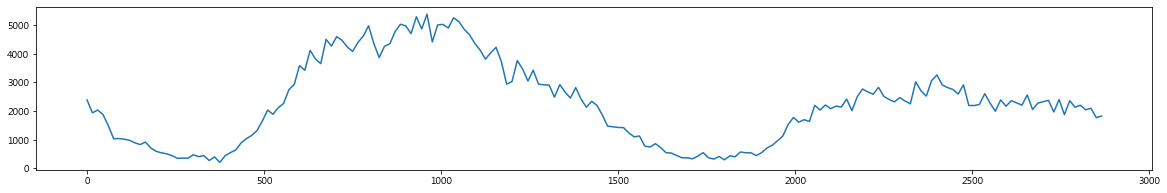

In [38]:
plt.figure(figsize = (20,3))
plt.plot(pv['elapsed(int)'], pv['rowuuid'])

#### 전체 PV 대비 아이폰(iPhone)에서 동작하는 어플리케이션의 PV의 변화량.

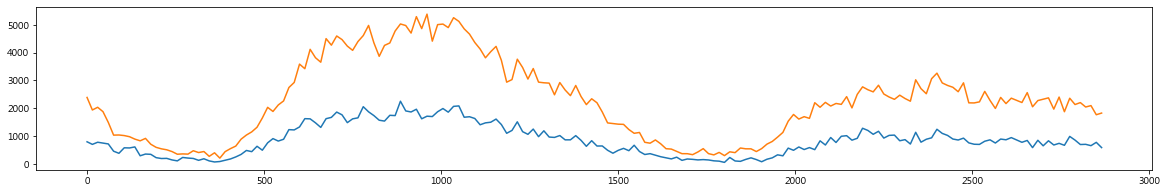

In [39]:
# lineplot 선 2개 (전체 pv, iphone pv)

plt.figure(figsize = (20,3))
plt.plot(pv['elapsed(int)'], pv['devicetype'])
plt.plot(pv['elapsed(int)'], pv['rowuuid'])

#### 전체 PV 대비 특정 버전(ex: 4.0.4)에서 동작하는 PV  변화량

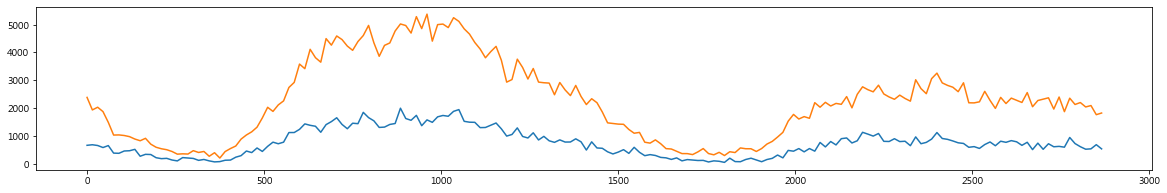

In [40]:
# lineplot 선 2개 (전체 pv, 4.0.4 pv)
plt.figure(figsize = (20,3))
plt.plot(pv['elapsed(int)'], pv['appversion'])
plt.plot(pv['elapsed(int)'], pv['rowuuid'])

### 함수 시각화 : ```plot_pageview```
* ostype, osversion, devicetype, appversion 모두 하나의 문자열 또는 리스트를 넣을 수 있다.
* 이 경우 인자로 넣은 정보에 해당하는 조건만 별도로 시각화.
* 이 인자의 기본 값은 None. 이 경우 해당 조건으로 별도 시각화를 하지 않는다.

In [43]:
def plot_pageview(ostype = None, osversion = None, devicetype = None, appversion = None):
    # log_userid 테이블에서, 입력된 변수에 맞는 행제약, 컬럼만 뽑아오기.
    x = merge[['eventdatetime', 'ostype', 'osversion', 
                    'devicetype', 'appversion']].reset_index().set_index('eventdatetime')
    x.loc[x['ostype'] != ostype, 'ostype'] = np.nan
    x.loc[x['osversion'] != osversion, 'osversion'] = np.nan
    x.loc[x['devicetype'] != devicetype, 'devicetype'] = np.nan
    x.loc[x['appversion'] != appversion, 'appversion'] = np.nan
    # 각 값들 count, 시간단위는 15분기준으로 grouping, timezone 제거
    pv = x.groupby(pd.Grouper(freq='15Min'))[['rowuuid', 'ostype',
                                              'osversion', 'devicetype', 'appversion']].count()
    pv = pd.DataFrame(pv).reset_index()
    pv['eventdatetime'] = pv['eventdatetime'].dt.tz_localize(None)
    
    # 시간값을 48시간 = 2880분으로 맞춤. (elapesed(int): 경과시간)
    date = datetime.datetime.strptime('2018-09-28 00:00:00', '%Y-%m-%d %H:%M:%S')
    pv['elapsed(int)'] = (pd.to_datetime(pv['eventdatetime'])- date).astype('int64')/60000000000 
    # microsecond -> minutes
    pv['elapsed(int)'].astype('int64')
    
    # 시각화
    plt.figure(figsize = (20,3))
    plt.plot(pv['elapsed(int)'], pv['rowuuid'])
    plt.plot(pv['elapsed(int)'], pv['osversion'])
    plt.plot(pv['elapsed(int)'], pv['devicetype'])
    plt.plot(pv['elapsed(int)'], pv['appversion'])
    pass

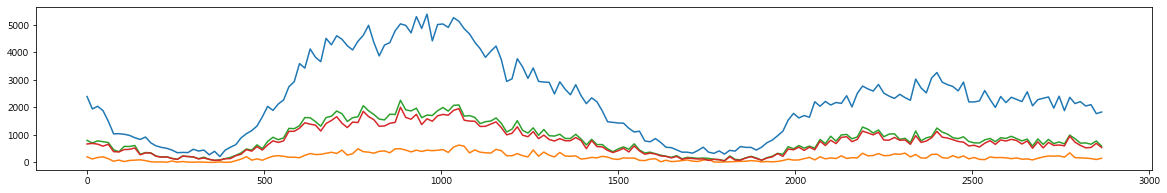

In [44]:
plot_pageview(ostype = 'iOS', osversion = '12.0', 
              devicetype = 'iPhone', appversion = '4.0.4')

# 3. 추가 분석, 시각화 & insight 도출

## 1) 시간대별 유입자수 / 구매전환 분석

### 시간대별 유입자수 확인

In [45]:
merge['day'] = merge['eventdatetime'].dt.day # day컬럼 생성
merge['hour'] = merge['eventdatetime'].dt.hour # hour 컬럼 생성

In [46]:
day_hour = merge.reset_index().sort_values(by=['day', 'hour'])
day_hour.head()

,userid,rowuuid,eventdatetime,devicemanufacturer,devicetype,ostype,osversion,appversion,eventcategory,viewid,viewaction,funnel desc,viewid desc,categoryname,category1,category2,category3,sourcetype,channel,params_campaign,params_medium,params_term,isfirstactivity,isfirstgoalactivity,day,hour
0,F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957,fd2a188c-bc9b-4702-9c47-b546b2614817,2018-09-28 00:00:00+09:00,Apple,iPhone,iOS,11.4.1,4.0.4,goal,home,view,홈,홈 (탭),NaN,NaN,NaN,NaN,unattributed,unattributed,NaN,NaN,NaN,False,False,28,0
1,F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957,a7b83557-49de-4728-9e00-762c923d3905,2018-09-28 00:00:43+09:00,Apple,iPhone,iOS,11.4.1,4.0.4,goal,category_list,view,카테고리,카테고리 목록 (탭),NaN,NaN,NaN,NaN,unattributed,unattributed,NaN,NaN,NaN,True,True,28,0
2,F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957,8e91ee55-dc1e-45c4-85bb-0f12cc5d9ee5,2018-09-28 00:00:47+09:00,Apple,iPhone,iOS,11.4.1,4.0.4,goal,category_gig,view,카테고리,카테고리-상품목록,디자인,디자인,NaN,NaN,unattributed,unattributed,NaN,NaN,NaN,True,True,28,0
3,F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957,2c10e944-d3da-44a4-9aea-2ff82eddeb9a,2018-09-28 00:00:52+09:00,Apple,iPhone,iOS,11.4.1,4.0.4,goal,category_list,view,카테고리,카테고리 목록 (탭),NaN,NaN,NaN,NaN,unattributed,unattributed,NaN,NaN,NaN,False,False,28,0
4,F36FAA62-ADAC-4AA5-9B00-1FD6CB7EE957,ed813149-6879-4f9c-a97d-ca5cba6a2e18,2018-09-28 00:00:54+09:00,Apple,iPhone,iOS,11.4.1,4.0.4,goal,bookmarks_gig,view,찜하기,메뉴목록-찜목록-서비스,NaN,NaN,NaN,NaN,unattributed,unattributed,NaN,NaN,NaN,True,True,28,0


In [47]:
### 유입확인 : eventcategory가 'launchlnSession'인 경우 (세션시작의미)
# 28일만
table_28 = pd.pivot_table(day_hour[day_hour['day']==28],
              index = 'hour',
              columns = 'eventcategory',
            values = 'rowuuid',
              fill_value = 0,
              aggfunc=len)
table_28.head()

eventcategory,background,deeplinkLaunch,exit,foreground,goal,install,launch,launchInSession
hour,,,,,,,,
0,795,1,180,372,6306,32,437,116
1,503,2,93,256,3363,23,283,66
2,294,0,57,153,2876,12,192,39
3,235,0,24,114,1849,9,116,14
4,119,0,32,41,1210,8,91,13


In [48]:
# 29일만
table_29 = pd.pivot_table(day_hour[day_hour['day']==29],
              index = 'hour',
              columns = 'eventcategory',
            values = 'rowuuid',
              fill_value = 0,
              aggfunc=len)

#### pointplot으로 시간대별 시각화

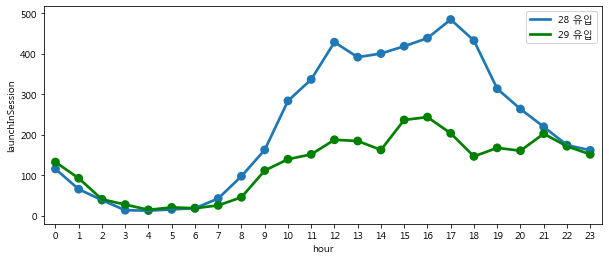

In [49]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# matplotlib의 subplots를 사용
figure,ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(10, 4)

# pointplot으로 시각화
sns.pointplot(data=table_28, x=table_28.index, y="launchInSession", label= '28 유입')
sns.pointplot(data=table_29, x=table_29.index, y="launchInSession", color ='green' ,label='29 유입')
ax.legend(handles=ax.lines[::len(table_28)+1], labels=['28 유입', '29 유입'])

### => 분석결과 (시간대별 유입)
 - 유입율 피크 시간대 : 12시 (점심 시작시간), 16~17시 (퇴근전시간), 21시
 - 제안 : 유입 극대화 프로모션의 경우 -> 위 피크시간대를 중심으로 집중하여 광고 집행 필요
 - 광고비 효율을 위해 새벽 2시~8시타임은 집행하지 않아도 좋을듯하나, '시간대별 구매전환' 그래프와 함께 확인 필요.

### 시간대별 '구매 전환' 확인

In [50]:
# 28일만 funnel desc == '결제 완료' 인 경우 count(len)
timeorder_28 = pd.pivot_table(day_hour[day_hour['day']==28],
              index = 'hour',
              columns = 'funnel desc',
            values = 'rowuuid',
              fill_value = 0,
              aggfunc=len)
timeorder_28['결제완료'].head(10)

hour
0     3
1     1
2     3
3     2
4     1
5     0
6     2
7     3
8     5
9    13
Name: 결제완료, dtype: int64

In [51]:
# 29일만
timeorder_29 = pd.pivot_table(day_hour[day_hour['day']==29],
              index = 'hour',
              columns = 'funnel desc',
            values = 'rowuuid',
              fill_value = 0,
              aggfunc=len)

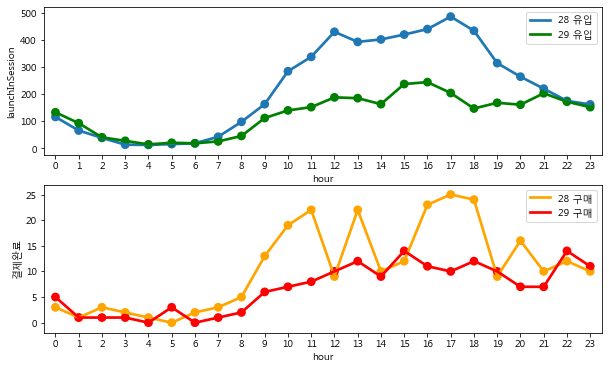

In [52]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# matplotlib의 subplots를 사용
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(10, 6)

# pointplot으로 시각화
sns.pointplot(data=table_28, x=table_28.index, y="launchInSession", label= '28 유입', ax=ax1)
sns.pointplot(data=table_29, x=table_29.index, y="launchInSession", color ='green' ,label='29 유입', ax=ax1)
sns.pointplot(data=timeorder_28, x=timeorder_28.index, y="결제완료", color = 'orange', label= '28 구매', ax=ax2)
sns.pointplot(data=timeorder_29, x=timeorder_29.index, y="결제완료", color = 'red', label= '29 구매', ax=ax2)

ax1.legend(handles=ax1.lines[::len(table_28)+1], labels=['28 유입', '29 유입'])
ax2.legend(handles=ax2.lines[::len(timeorder_28)+1], labels=['28 구매', '29 구매'])

### => 분석결과 (시간대별 구매전환)
- 시간대별 유입수와 전체적으로 비슷한 양상을 띔
- 구매수 피크의 경우 오후시간뿐 아니라, 밤 10시에서도 구매가 많이 일어나는 추가 인사이트 발견.
- 구매전환 캠페인의 경우 오후와 저녁시간대를 양분하여 진행하여도 좋을듯

## 2) 유입 채널별 전환

In [53]:
## 채널별 결제완료수 
complete = pd.pivot_table(merge.reset_index(),
                       index=['sourcetype','channel'], columns='funnel desc',
                       values = "rowuuid", fill_value=0, aggfunc=len) 
complete[['결제', '결제완료']]

funnel desc                          결제  결제완료
sourcetype   channel                         
app-market   google-play             56    10
paid         apple.searchads          0     0
             google.adwords           6     2
stranger     (not set)               13     5
             google                  15     3
unattributed unattributed          1049   365
viral        WEB                    139    32
             facebook                 0     0
             m_daum                  11     1
             m_naver                  1     0
             m_naverpowercontents     0     0
             pc_naver                 0     0

### 결과 :  (unattributed는 제외) WEB > google-play > google > google_adwords 순으로 구매전환이 높다.
유입채널별 '유입 -> 결제완료' 페이지로 넘어가는 전환율을 확인해보자.

In [56]:
#채널별 유입수 'launch'
acquisition = pd.pivot_table(log_userid.reset_index(),
                       index=['sourcetype','channel'], columns='eventcategory',
                       values = "rowuuid", fill_value=0, aggfunc=len) 
acquisition

eventcategory                      deeplinkLaunch    goal  install  launch
sourcetype   channel                                                      
app-market   google-play                        0   18718      245    1010
paid         apple.searchads                    0     649       14      34
             google.adwords                     0    3607      308     161
stranger     (not set)                          0    2310       26     108
             google                             0    2988       56     142
unattributed unattributed                      17  247382      615   22820
viral        WEB                                0   26039      242    1358
             facebook                           0     117        5       4
             m_daum                             0     925        9      32
             m_naver                            0     777       24      48
             m_naverpowercontents               0     135        4       9
             pc_naver                           0     212        0      15

In [57]:
# 채널별 구매전환율(%) : 결제완료 / 유입수 *100
channel_complete = round(complete['결제완료']/acquisition['launch']*100, 2)
channel_complete = pd.DataFrame(channel_complete)
channel_complete.columns = ['구매전환율(%)']
# not set, unattributed 비교대상에서 제외
channel_complete = channel_complete[channel_complete.index.get_level_values(1) != '(not set)']
channel_complete = channel_complete[channel_complete.index.get_level_values(1) != 'unattributed']
channel_complete

구매전환율(%)
sourcetype channel                       
app-market google-play               0.99
paid       apple.searchads           0.00
           google.adwords            1.24
stranger   google                    2.11
viral      WEB                       2.36
           facebook                  0.00
           m_daum                    3.12
           m_naver                   0.00
           m_naverpowercontents      0.00
           pc_naver                  0.00

### 분석 결과
* '결제완료' 기본 수치들이 낮아서, 채널별 '전환율'을 따지기엔 유의미하지 않다고 봄. 
* -> 예) m_daum의 경우 전환율이 3.12% 지만, 실제 결제완료 건수는 1개이다. 분석에 혼선을 줄 수 있음.

## 3) OS별 설치/실행 - 활동 비교

In [58]:
# ostype 별 비교
ostype = pd.pivot_table(data = merge.reset_index(),
         index = 'ostype',
         columns = 'eventcategory',
         values = 'rowuuid', 
         aggfunc = len)
# index 순서 변경 
ostype_data = ostype[['install', 'launch', 'deeplinkLaunch',
                'launchInSession', 'goal', 'background', 'foreground','exit']]
ostype_data

eventcategory,install,launch,deeplinkLaunch,launchInSession,goal,background,foreground,exit
ostype,,,,,,,,
Android,1137.0,15253.0,46.0,5723.0,197802.0,27334.0,13001.0,10382.0
iOS,411.0,10755.0,NaN,2668.0,106057.0,27811.0,15864.0,NaN


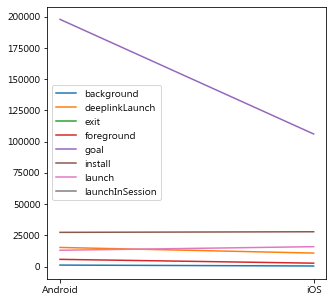

In [59]:
plt.figure(figsize = (5,5))
plt.plot(ostype_data)
plt.legend(labels = ostype.columns)

### 단순 데이터 갯수로는 Android 가 전체적으로 높다. 그러나, 'Install'을 한 유저들을 기준으로, 활동 비율을 살펴보면?

### install 수 대비, 실행, 활동비율 비교

In [60]:
# install 값을 기준으로 각 활동의 비율을 계산하여 컬럼 생성. 
# 계산식 : 활동컬럼값 / 인스톨컬럼값
ostype['launch%'] = ostype['launch']/ostype['install']
ostype['deeplinkLaunch%'] = ostype['deeplinkLaunch']/ostype['install']
ostype['launchInSession%'] = ostype['launchInSession']/ostype['install']
ostype['goal%'] = ostype['goal']/ostype['install']
ostype['background%'] = ostype['background']/ostype['install']
ostype['foreground%'] = ostype['foreground']/ostype['install']
ostype['exit%'] = ostype['exit']/ostype['install']
ostype_ratio = ostype[['launch%', 'deeplinkLaunch%',
       'launchInSession%', 'goal%', 'background%', 'foreground%', 'exit%']]
ostype_ratio

eventcategory,launch%,deeplinkLaunch%,launchInSession%,goal%,background%,foreground%,exit%
ostype,,,,,,,
Android,13.415128,0.040457,5.033421,173.968338,24.040457,11.434477,9.131047
iOS,26.167883,NaN,6.491484,258.046229,67.666667,38.598540,NaN


Text(0.5, 1.0, 'install 수 대비 data')

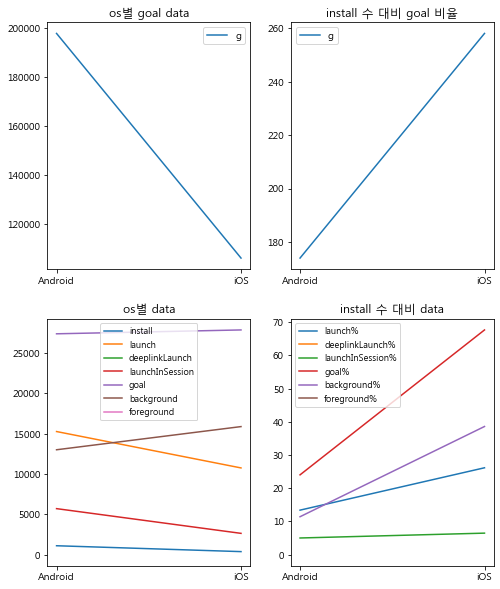

In [61]:
# 단순 활동 수 vs install대비 비율 시각화 비교
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(8, 10)

ax1.plot(ostype_data['goal'])
ax1.legend(labels = 'goal')
ax1.set_title('os별 goal data')

ax2.plot(ostype_ratio['goal%'])
ax2.legend(labels = 'goal%')
ax2.set_title('install 수 대비 goal 비율')

ax3.plot(ostype_data.loc[:, ostype_data.columns != 'goal'])
ax3.legend(labels = ostype_data.columns, prop = {'size':9})
ax3.set_title('os별 data')

ax4.plot(ostype_ratio.loc[:, ostype_ratio.columns != 'goal%'])
ax4.legend(labels = ostype_ratio.columns, prop = {'size':9})
ax4.set_title('install 수 대비 data')

### 분석결과
- 단순 횟수로 설치, 실행, 활동은 Android 가 높으나, 설치횟수를 기준으로한 활동의 비율은 ios가 훨씬 높다.
- -> 사용자중 Android 기기 유저가 많지만, 설치 후 활용하는 비중은 iPhone 이 더 많다는 뜻.
- ->> 안드로이드와 iOS 앱 UX 비교, 서비스기획단에서 안드로이드 사용자 경험 증대 필요

## 4) category 상품별 Funnel (구매전환) 분석
- 탐색결과, 카테고리 depth가 가장 깊은 category3에 방문한 후 '결제'로 이어진다.
- category3 컬럼 - funnel 컬럼을 비교하면
- -> 카테고리별 방문 -> 결제 전환율/이탈률 분석이 가능

In [62]:
# 카테고리별 funnel 값 확인
merge.loc[(pd.notnull(merge['category3'])), ['category3', 'viewaction', 'funnel desc']].head(100)

category3  \
userid                               rowuuid                                          
8a871e50-0717-4aed-9bad-04ac3c3793be e62dccef-dd70-4415-8a33-c8324ddaed38     자기소개서   
                                     a6d462c3-d4a3-4a2c-8942-88f2cae0012e     자기소개서   
                                     7d06d33e-cd1f-4064-a3d3-cb947424ff97     자기소개서   
                                     497ae46f-6749-4094-853f-d5b0b33e18fc     자기소개서   
                                     291c4d91-86c2-4102-b6c9-070bee255a4d     자기소개서   
...                                                                             ...   
5A5BD32B-66AF-467C-8198-A8EED04B0571 d467d35f-988b-478e-9983-3052c9fd32de    3D 프린팅   
                                     5a2091f1-621f-4ed9-b86d-3aa7a78248b2     제품디자인   
                                     a90d203d-7b56-48aa-bebe-efcb124af128     제품디자인   
                                     a867ef79-edf3-4783-99e2-b7bf61424354     제품디자인   
                                     15ce1555-0f72-4c92-a62d-1dc026ca508f     제품디자인   

                                                                          viewaction  \
userid                               rowuuid                                           
8a871e50-0717-4aed-9bad-04ac3c3793be e62dccef-dd70-4415-8a33-c8324ddaed38       view   
                                     a6d462c3-d4a3-4a2c-8942-88f2cae0012e       view   
                                     7d06d33e-cd1f-4064-a3d3-cb947424ff97       view   
                                     497ae46f-6749-4094-853f-d5b0b33e18fc       view   
                                     291c4d91-86c2-4102-b6c9-070bee255a4d       view   
...                                                                              ...   
5A5BD32B-66AF-467C-8198-A8EED04B0571 d467d35f-988b-478e-9983-3052c9fd32de       view   
                                     5a2091f1-621f-4ed9-b86d-3aa7a78248b2       view   
                                     a90d203d-7b56-48aa-bebe-efcb124af128       view   
                                     a867ef79-edf3-4783-99e2-b7bf61424354       view   
                                     15ce1555-0f72-4c92-a62d-1dc026ca508f       view   

                                                                          funnel desc  
userid                               rowuuid                                           
8a871e50-0717-4aed-9bad-04ac3c3793be e62dccef-dd70-4415-8a33-c8324ddaed38          상품  
                                     a6d462c3-d4a3-4a2c-8942-88f2cae0012e          상품  
                                     7d06d33e-cd1f-4064-a3d3-cb947424ff97          상품  
                                     497ae46f-6749-4094-853f-d5b0b33e18fc          상품  
                                     291c4d91-86c2-4102-b6c9-070bee255a4d          상품  
...                                                                               ...  
5A5BD32B-66AF-467C-8198-A8EED04B0571 d467d35f-988b-478e-9983-3052c9fd32de          상품  
                                     5a2091f1-621f-4ed9-b86d-3aa7a78248b2          상품  
                                     a90d203d-7b56-48aa-bebe-efcb124af128          상품  
                                     a867ef79-edf3-4783-99e2-b7bf61424354          상품  
                                     15ce1555-0f72-4c92-a62d-1dc026ca508f          상품  

[100 rows x 3 columns]

#### 탐색결과
- category3의 상세페이지 방문했을 경우 : funnel '상품'
- 구매로 이어질 경우 : funnel '결제'
- 결제까지 완료할 경우 : funnel '결제완료'

In [63]:
# pivot table 로 category3 - funnel 값 count 해본다.
cat3 = merge.loc[(pd.notnull(merge['category3'])), ['category3', 'viewaction', 'funnel desc']].head(999)
pd.pivot_table(data=cat3.reset_index(), index = 'category3', columns = 'funnel desc',
              values = 'rowuuid', aggfunc=len).head(20)

funnel desc,결제,결제완료,상품,카테고리
category3,,,,
3D 프린팅,NaN,NaN,3.0,NaN
HTML·CSS 퍼블리싱,NaN,NaN,10.0,NaN
계정운영,NaN,NaN,7.0,3.0
공간디자인,NaN,NaN,5.0,NaN
관리운영,2.0,NaN,50.0,1.0
광고 카피라이팅,NaN,NaN,2.0,NaN
구독자·팔로워,1.0,NaN,65.0,NaN
그래픽 UI,NaN,NaN,10.0,NaN
기업명·슬로건,NaN,NaN,21.0,NaN


### 카테고리별 '결제' top5

In [64]:
cat_pivot = pd.pivot_table(data=cat3.reset_index(), index = 'category3', columns = 'funnel desc',
              values = 'rowuuid', aggfunc=len)
cat_pivot = cat_pivot[['상품', '결제', '결제완료']]
cat_pivot = cat_pivot.sort_values(by='결제', ascending=False)
cat_pivot.head()

funnel desc,상품,결제,결제완료
category3,,,
홍보,77.0,10.0,5.0
자기소개서,173.0,3.0,1.0
관리운영,50.0,2.0,NaN
트래픽,29.0,2.0,NaN
구독자·팔로워,65.0,1.0,NaN


#### 전환/이탈률 파악

In [65]:
# 단계별 전환율 컬럼 생성
cat_pivot['CVR(결제/상품)%'] =round(cat_pivot['결제']/cat_pivot['상품'], 2) *100
cat_pivot['CVR(결제완료/결제)%'] =round(cat_pivot['결제완료']/cat_pivot['결제'],2) *100
cat_pivot.head()

funnel desc,상품,결제,결제완료,CVR(결제/상품)%,CVR(결제완료/결제)%
category3,,,,,
홍보,77.0,10.0,5.0,13.0,50.0
자기소개서,173.0,3.0,1.0,2.0,33.0
관리운영,50.0,2.0,NaN,4.0,NaN
트래픽,29.0,2.0,NaN,7.0,NaN
구독자·팔로워,65.0,1.0,NaN,2.0,NaN


In [66]:
# 컬럼 정렬
cat_pivot = cat_pivot[['상품', 'CVR(결제/상품)%', '결제', 'CVR(결제완료/결제)%','결제완료']]
cat_pivot.head(10)

funnel desc,상품,CVR(결제/상품)%,결제,CVR(결제완료/결제)%,결제완료
category3,,,,,
홍보,77.0,13.0,10.0,50.0,5.0
자기소개서,173.0,2.0,3.0,33.0,1.0
관리운영,50.0,4.0,2.0,NaN,NaN
트래픽,29.0,7.0,2.0,NaN,NaN
구독자·팔로워,65.0,2.0,1.0,NaN,NaN
질문답변·기타,13.0,8.0,1.0,100.0,1.0
3D 프린팅,3.0,NaN,NaN,NaN,NaN
HTML·CSS 퍼블리싱,10.0,NaN,NaN,NaN,NaN
계정운영,7.0,NaN,NaN,NaN,NaN


#### '결제'-'결제완료'의 이탈률의 경우 크게 유의미하지 않다고 판단하여 제외
- 모수가 너무 작다. (결제완료 1,2회)
- 서드파티앱 카드결제 등으로 '결제' 페이지 다수 방문한 경우들이 있기도.

In [67]:
# '결제' 컬럼 제외하고, '상품'-'결제완료'간의 전환율만 파악
cat_pivot['CVR(결제완료/상품)%'] = round(cat_pivot['결제완료']/cat_pivot['상품'],2) *100
cat_pivot2 = cat_pivot[['상품','CVR(결제완료/상품)%', '결제완료']]
cat_pivot2.sort_values(by = ['CVR(결제완료/상품)%','상품'], ascending=False).head(10)

funnel desc,상품,CVR(결제완료/상품)%,결제완료
category3,,,
질문답변·기타,13.0,8.0,1.0
홍보,77.0,6.0,5.0
자기소개서,173.0,1.0,1.0
카페·블로그,77.0,NaN,NaN
포스팅,72.0,NaN,NaN
구독자·팔로워,65.0,NaN,NaN
웹사이트 제작,52.0,NaN,NaN
관리운영,50.0,NaN,NaN
연관검색·자동완성,47.0,NaN,NaN


### >> 결론
- '구독자-팔로워' 카테고리의 경우 '홍보' 대비 이탈률이 높음.
- '포스팅', '카페블로그', '웹사이트제작/개선'의 경우, 구매전환이 발생한 카테고리대비 상품view수는 높으나 전환이 없다. 
- -> 전환을 높히기 위한 페이지 개선 및 품목 전체적인 리뉴얼 제안.